## LSTM METHOD IMPLEMENTATION

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [3]:
# Basic utilities
import os
import platform
import re
import ast

# Data handling and manipulation
import numpy as np
import pandas as pd

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob
import contractions

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation, data splitting, and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)

# TensorFlow and Keras utilities for deep learning
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch


In [13]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [14]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [15]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project Code/Tweets.csv'
df = pd.read_csv(data_pth)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [16]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


In [17]:
def check_missing_data(dataframe):
    """
    Check for missing data in the dataframe.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to inspect.
    
    Returns:
    - pd.Series: A series containing counts of missing data for each column.
    """
    return dataframe.isnull().sum()

# Display the number of missing values for each column
print("Missing Values:\n", check_missing_data(df))

# Remove rows with missing values
df.dropna(inplace=True)
print(f"Post Filtering Step-1: Total Rows - {len(df)}")

Missing Values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Post Filtering Step-1: Total Rows - 27480


In [18]:
def custom_handle_contractions(text):
    """
    Expand contractions in the provided text using a predefined contractions dictionary.
    This function handles contractions formed both with standard apostrophes and backticks.
    
    Args:
    - text (str): The input text containing contractions.
    
    Returns:
    - str: The input text with all recognized contractions expanded.
    
    """
    
    # Define a dictionary of contractions and their expanded forms
    contractions_dict = contractions.contractions_dict
    
    # Replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        # Handle both apostrophes and backticks
        text = text.replace(contraction, expansion)
        text = text.replace(contraction.replace("'", "`"), expansion)

    return text

# Applying it to the DataFrame
df['text'] = df['text'].apply(custom_handle_contractions)


In [19]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I would have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why could not they put them on ...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I have wondered about rake to. The client ha...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [20]:
def clean_text(text):
    """
    Clean the provided text by removing URLs, mentions, numbers, hashtags, non-ASCII characters, and converting to lowercase.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The cleaned text.
    """
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text

df['cleaned_tweets'] = df['text'].apply(clean_text)


In [21]:
def retain_required_columns(df, required_columns):
    """
    Retains only the specified required columns in the DataFrame and drops all others.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - required_columns (list): List of column names to retain.
    
    Returns:
    - pd.DataFrame: DataFrame containing only the required columns.
    """
    
    # Check if required columns are present in the dataframe
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are not present in the DataFrame: {missing_columns}")
    
    return df[required_columns]


df = retain_required_columns(df, ['sentiment', 'cleaned_tweets'])

In [22]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [23]:
# Detect all duplicates based on the 'cleaned_text' column
duplicates_mask = df.duplicated(subset='cleaned_tweets', keep=False)

# Remove all rows with duplicate 'cleaned_text'
df = df[~duplicates_mask]

In [24]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [25]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11030
positive     8435
negative     7735
Name: sentiment, dtype: int64
neutral     40.551471
positive    31.011029
negative    28.437500
Name: sentiment, dtype: float64


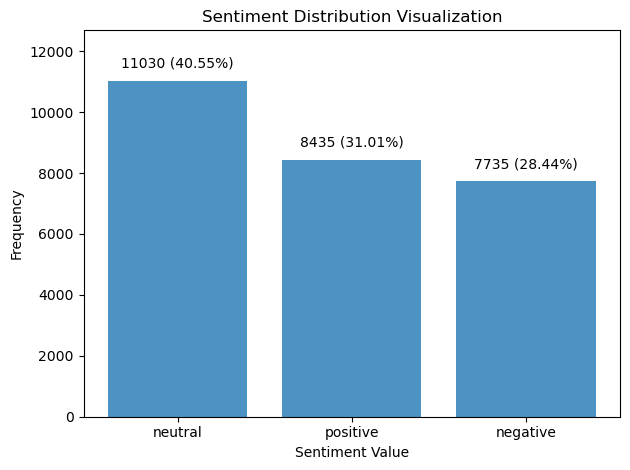

In [26]:
import matplotlib.pyplot as plt

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = df['sentiment'].value_counts()
sentiment_ratio = df['sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [27]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250

def tokenize_and_pad(data):
    """
    Tokenizes and pads input data sequences.
    
    Args:
        data (list): A list of text data to be tokenized and padded.
    
    Returns:
        ndarray: Tokenized and padded data.
    """
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)
    return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH),tokenizer

In [28]:
def split_data(X, Y, test_size=0.3, val_split=0.5):
    """
    Splits data into training, validation, and testing sets.
    
    Args:
        X (ndarray): Features data.
        Y (ndarray): Labels data.
        test_size (float): Proportion of test data.
        val_split (float): Proportion of validation data from test data.
    
    Returns:
        tuple: Training, validation, and test sets for features and labels.
    """
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=test_size, random_state=5)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=val_split, random_state=5)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [29]:
def plot_training_history(history):
    """
    Plot training & validation accuracy and loss.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

def plot_confusion_matrix(Y_true, Y_pred_classes):
    """
    Plot the confusion matrix using Seaborn.
    """
    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def print_misclassified_sentences(Y_true, Y_pred_classes, X_data_indices, processed_df):
    """
    Print misclassified sentences using original DataFrame.
    """
    misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
    for idx in misclassified_idx:
        true_label = Y_true[idx]
        pred_label = Y_pred_classes[idx]
        original_text = processed_df.iloc[X_data_indices[idx]]['Headlines']
        print(f"Original label: {true_label} - Predicted: {pred_label} - Text: {original_text}")


In [10]:
def compute_FPR_spec_metrics(cm, labels=["negative", "neutral" , "positive"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


## The Implementation of sequential LSTM Model

In [30]:
def build_model(hp, max_nb_words=MAX_NB_WORDS, input_length=MAX_SEQUENCE_LENGTH):
    """
    Builds a LSTM model for sentiment analysis.
    
    Args:
        hp (HyperParameters): Hyperparameters for the model.
        max_nb_words (int): Maximum number of words for the Embedding layer.
        input_length (int): Input length for the Embedding layer.
    
    Returns:
        Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(max_nb_words, hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(LSTM(hp.Int('lstm_units', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
def run_tuner(batch_size, X_train, Y_train, X_val, Y_val, project_name):
    """
    Runs the Keras tuner for hyperparameter optimization.
    
    Args:
        batch_size (int): Batch size for training.
        X_train (ndarray): Training features.
        Y_train (ndarray): Training labels.
        X_val (ndarray): Validation features.
        Y_val (ndarray): Validation labels.
        project_name (str): Name of the tuning project.
    """
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name)
    
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

In [34]:
X,tokenizer = tokenize_and_pad(df['cleaned_tweets'].values)# Tokenizer used here is for the misclassification report
Y = pd.get_dummies(df['sentiment']).values

X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

run_tuner(32, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_32')
run_tuner(64, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_64')
run_tuner(128, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_128')

Trial 10 Complete [00h 19m 07s]
val_accuracy: 0.6930147111415863

Best val_accuracy So Far: 0.6950980424880981
Total elapsed time: 05h 35m 38s
INFO:tensorflow:Oracle triggered exit


In [39]:
def print_hyperparameters(hps):
    for hp, value in hps.values.items():
        print(f"{hp}: {value}")

In [40]:
def tuner_reload(project_name):
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name
    )
    tuner.reload()
    print(f"Hyperparameter values for {project_name}")    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print_hyperparameters(best_hps)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    # Modify the metric retrieval line
    best_val_accuracy = best_trial.metrics.metrics['val_accuracy'].get_best_value()
    print(f"Best validation accuracy: {best_val_accuracy}")

In [41]:
tuner_reload('SentimentAnalysis_32')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_32/tuner0.json
Hyperparameter values for SentimentAnalysis_32
embedding_dim: 384
dropout_rate: 0.45
lstm_units: 416
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 384)          19200000  
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 384)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 416)               1332864   
                                                                 
 dense (Dense)               (None, 3)                 1251      
                                                                 
Total params: 20534115 (78.33 MB)
Trainable params: 20534115 (78.33 MB)
Non

In [42]:
tuner_reload('SentimentAnalysis_64')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_64/tuner0.json
Hyperparameter values for SentimentAnalysis_64
embedding_dim: 96
dropout_rate: 0.35000000000000003
lstm_units: 288
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 96)           4800000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 96)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 288)               443520    
                                                                 
 dense (Dense)               (None, 3)                 867       
                                                                 
Total params: 5244387 (20.01 MB)
Trainable params: 5244387 (2

In [43]:
tuner_reload('SentimentAnalysis_128')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_128/tuner0.json
Hyperparameter values for SentimentAnalysis_128
embedding_dim: 64
dropout_rate: 0.1
lstm_units: 384
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           3200000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 64)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 384)               689664    
                                                                 
 dense (Dense)               (None, 3)                 1155      
                                                                 
Total params: 3890819 (14.84 MB)
Trainable params: 3890819 (14.84 MB)
Non-t

#### The best results were obtained by 32 batch size. 

Epoch 1/10
595/595 [==============================] - 971s 2s/step - loss: 0.8471 - accuracy: 0.6172 - val_loss: 0.7057 - val_accuracy: 0.7010
Epoch 2/10
595/595 [==============================] - 942s 2s/step - loss: 0.5731 - accuracy: 0.7648 - val_loss: 0.7091 - val_accuracy: 0.7105
Epoch 3/10
595/595 [==============================] - 954s 2s/step - loss: 0.3987 - accuracy: 0.8475 - val_loss: 0.7700 - val_accuracy: 0.6966
Epoch 4/10
128/128 [==============================] - 49s 382ms/step


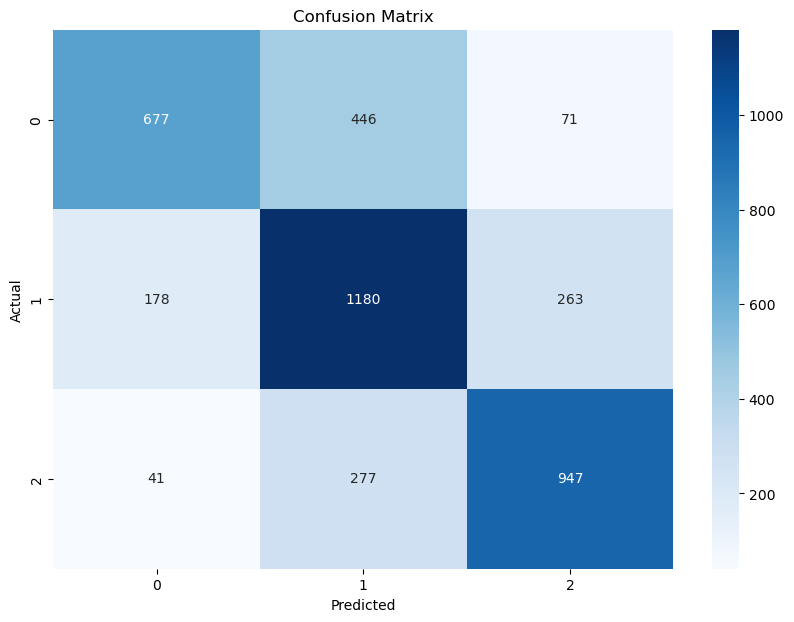

              precision    recall  f1-score   support

    Negative     0.7556    0.5670    0.6478      1194
     Neutral     0.6201    0.7279    0.6697      1621
    Positive     0.7393    0.7486    0.7439      1265

    accuracy                         0.6873      4080
   macro avg     0.7050    0.6812    0.6872      4080
weighted avg     0.6967    0.6873    0.6863      4080



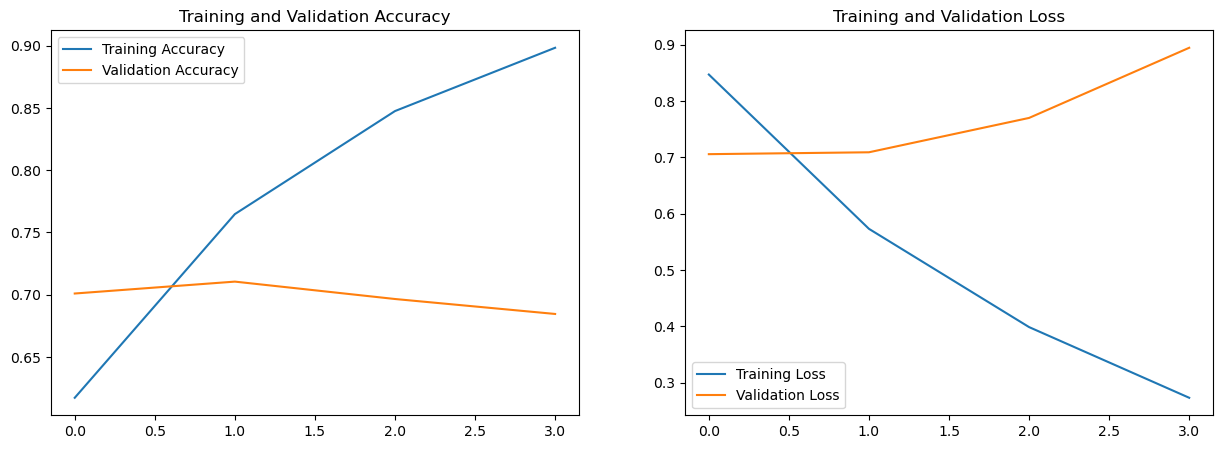

In [44]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 384, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.45))
model.add(LSTM(416, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)
Y_test_argmax = np.argmax(Y_test, axis=-1)

plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

plot_training_history(history)

In [11]:
cm = np.array([[677, 446, 71], 
               [178, 1180, 263], 
               [41, 277, 947]])

compute_FPR_spec_metrics(cm)

Metrics for class negative (Class value: 0):
Specificity: 0.9066
FPR: 0.0934
Precision: 0.7556

Metrics for class neutral (Class value: 1):
Specificity: 0.6919
FPR: 0.3081
Precision: 0.6201

Metrics for class positive (Class value: 2):
Specificity: 0.8476
FPR: 0.1524
Precision: 0.7393

Overall accuracy: 0.6873
Weighted average specificity: 0.803
Weighted average FPR: 0.197
Macro average specificity: 0.8154
Macro average FPR: 0.1846



In [45]:
def misclassification_report(model, X_test, Y_test, tokenizer, n_samples):
   
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

    def sequence_to_text(sequence):
        return ' '.join([reverse_word_map.get(word, '?') for word in sequence if word != 0])  # 0 is padding

    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=-1)
    Y_test_argmax = np.argmax(Y_test, axis=-1)

    misclassified_indices = np.where(test_pred != Y_test_argmax)[0]

    # Get the first n_samples misclassified indices, sentences, true labels, and predicted labels
    misclassified_sentences = [sequence_to_text(X_test[i]) for i in misclassified_indices[:n_samples]]
    true_labels = [Y_test_argmax[i] for i in misclassified_indices[:n_samples]]
    misclassified_labels = [test_pred[i] for i in misclassified_indices[:n_samples]]

    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

    # Print the first n_samples misclassified sentences along with their true and predicted labels
    for idx, (sentence, true_label, pred_label) in enumerate(zip(misclassified_sentences, true_labels, misclassified_labels)):
        print(f"{idx + 1}. {sentence}")
        print(f"   True Sentiment: {label_map[true_label]}")
        print(f"   Misclassified as: {label_map[pred_label]}\n")

In [46]:
misclassification_report(model, X_test, Y_test, tokenizer, n_samples=10)

128/128 [==============================] - 48s 374ms/step
1. how i wish the result is true
   True Sentiment: Neutral
   Misclassified as: Positive

2. making egg tart chinese egg pudding yum
   True Sentiment: Positive
   Misclassified as: Neutral

3. two macaroons go into a barone says oh your a nut wow i need to get out more
   True Sentiment: Positive
   Misclassified as: Neutral

4. on my way to school of my last friday of high school ever and i do not even get to see holly gabbie and hannah
   True Sentiment: Negative
   Misclassified as: Neutral

5. we drank ours away may day bank holiday today
   True Sentiment: Neutral
   Misclassified as: Positive

6. oh and i am obviously back on my stupid sleep schedule luckily church is not until tomorrow
   True Sentiment: Neutral
   Misclassified as: Negative

7. umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
   True Sentiment: Neutral
   Misclassified as: Positive

8.

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 384)          19200000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 384)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 416)               1332864   
                                                                 
 dense_1 (Dense)             (None, 3)                 1251      
                                                                 
Total params: 20534115 (78.33 MB)
Trainable params: 20534115 (78.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Stacked LSTM

In [51]:
def build_stacked_model(hp, max_nb_words=MAX_NB_WORDS, input_length=MAX_SEQUENCE_LENGTH):
    """
    Builds a stacked LSTM model for sentiment analysis.
    
    Args:
        hp (HyperParameters): Hyperparameters for the model.
        max_nb_words (int): Maximum number of words for the Embedding layer.
        input_length (int): Input length for the Embedding layer.
    
    Returns:
        Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(max_nb_words, hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(LSTM(hp.Int('lstm_units_1', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(hp.Int('lstm_units_2', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [52]:
def run_stacked_tuner(batch_size, X_train, Y_train, X_val, Y_val, project_name):
    """
    Runs the Keras tuner for hyperparameter optimization of the stacked LSTM model.
    
    Args:
        batch_size (int): Batch size for training.
        X_train (ndarray): Training features.
        Y_train (ndarray): Training labels.
        X_val (ndarray): Validation features.
        Y_val (ndarray): Validation labels.
        project_name (str): Name of the tuning project.
    """
    tuner = RandomSearch(
        build_stacked_model,  # note the change in the function name here
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name)
    
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


In [59]:
def tuner_reload_s(project_name):
    tuner = RandomSearch(
        build_stacked_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name
    )
    tuner.reload()
    
    best_hps_s = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model_s = tuner.get_best_models(num_models=1)[0]
    best_trial_s = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    best_val_accuracy = best_trial_s.metrics.metrics['val_accuracy'].get_best_value()
    
    print(f"""
    The hyperparameters search is complete. 
    The optimal number of units in the first LSTM layer is {best_hps_s.get('lstm_units_1')} 
    and the optimal number of units in the second LSTM layer is {best_hps_s.get('lstm_units_2')}.
    The optimal dropout rate is {best_hps_s.get('dropout_rate')}. 
    The optimal embedding dimension is {best_hps_s.get('embedding_dim')}.
    """)

    print(f"Best validation accuracy: {best_val_accuracy}")

    # Print best hyperparameters
    print("Best Hyperparameters:")
    print(best_hps_s.values)

    # Print best model summary
    print("Best Model Summary:")
    best_model_s.summary()

In [55]:
run_stacked_tuner(32, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_stacked')

Trial 10 Complete [04h 53m 48s]
val_accuracy: 0.7066176533699036

Best val_accuracy So Far: 0.7185049057006836
Total elapsed time: 1d 11h 05m 11s
INFO:tensorflow:Oracle triggered exit


In [60]:
# Reload the tuner and get the best hyperparameters, model, and validation accuracy.
tuner_reload_s('SentimentAnalysis_stacked')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_stacked/tuner0.json

    The hyperparameters search is complete. 
    The optimal number of units in the first LSTM layer is 352 
    and the optimal number of units in the second LSTM layer is 224.
    The optimal dropout rate is 0.4. 
    The optimal embedding dimension is 96.
    
Best validation accuracy: 0.7185049057006836
Best Hyperparameters:
{'embedding_dim': 96, 'dropout_rate': 0.4, 'lstm_units_1': 352, 'lstm_units_2': 224}
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 96)           4800000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 96)           0         
 Dropout1D)                                                      
                                                                

Epoch 1/10
298/298 [==============================] - 792s 3s/step - loss: 0.8900 - accuracy: 0.5765 - val_loss: 0.7363 - val_accuracy: 0.6924
Epoch 2/10
298/298 [==============================] - 820s 3s/step - loss: 0.6340 - accuracy: 0.7395 - val_loss: 0.6919 - val_accuracy: 0.7061
Epoch 3/10
298/298 [==============================] - 818s 3s/step - loss: 0.4909 - accuracy: 0.8058 - val_loss: 0.7335 - val_accuracy: 0.7032
Epoch 4/10
298/298 [==============================] - 799s 3s/step - loss: 0.3825 - accuracy: 0.8551 - val_loss: 0.7708 - val_accuracy: 0.6973
Epoch 5/10
128/128 [==============================] - 50s 390ms/step


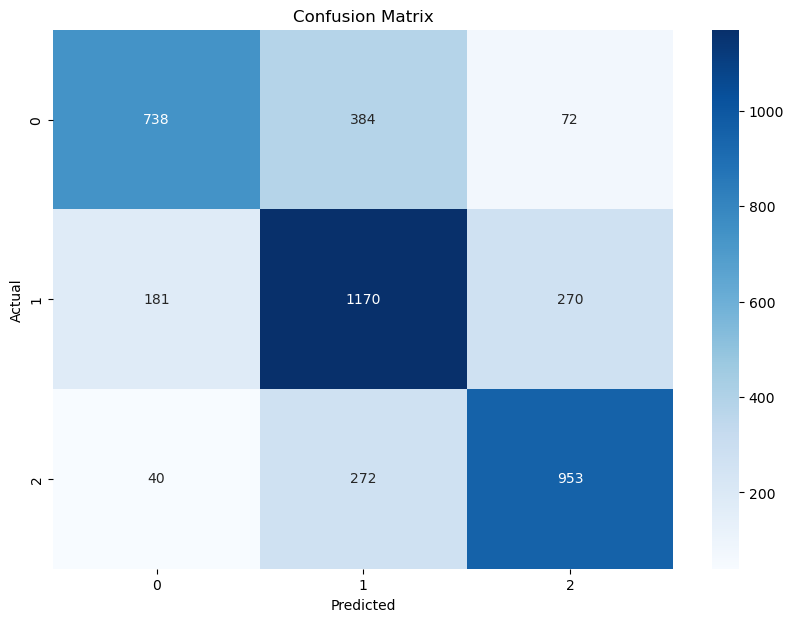

              precision    recall  f1-score   support

    Negative     0.7696    0.6181    0.6856      1194
     Neutral     0.6407    0.7218    0.6789      1621
    Positive     0.7359    0.7534    0.7445      1265

    accuracy                         0.7012      4080
   macro avg     0.7154    0.6977    0.7030      4080
weighted avg     0.7079    0.7012    0.7012      4080



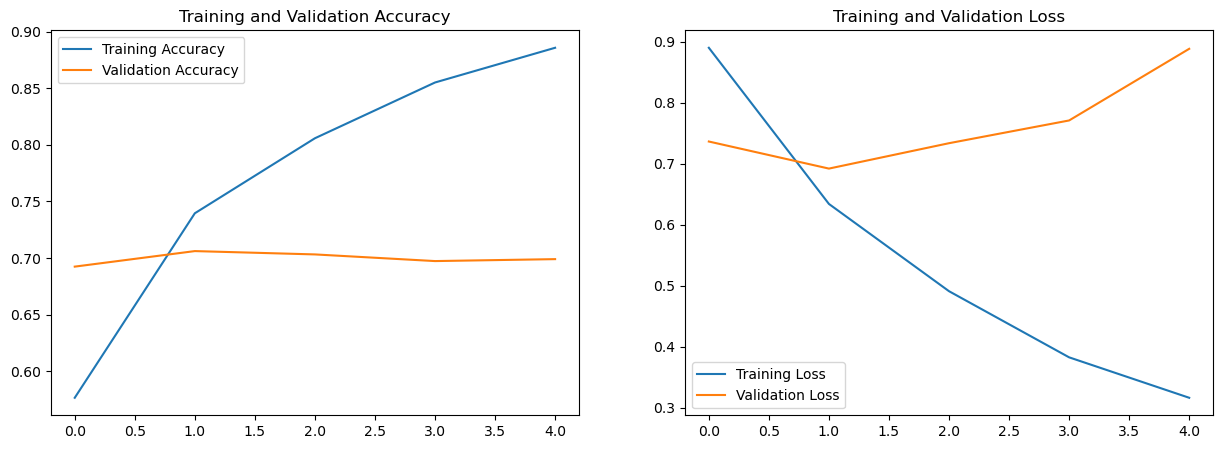

In [61]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 96, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(352, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(224, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)
Y_test_argmax = np.argmax(Y_test, axis=-1)

plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

plot_training_history(history)

In [12]:
cm = np.array([[738, 384, 72], 
               [181, 1170, 270], 
               [40, 272, 953]])

compute_FPR_spec_metrics(cm)

Metrics for class negative (Class value: 0):
Specificity: 0.9057
FPR: 0.0943
Precision: 0.7696

Metrics for class neutral (Class value: 1):
Specificity: 0.7205
FPR: 0.2795
Precision: 0.6407

Metrics for class positive (Class value: 2):
Specificity: 0.848
FPR: 0.152
Precision: 0.7359

Overall accuracy: 0.7012
Weighted average specificity: 0.8142
Weighted average FPR: 0.1858
Macro average specificity: 0.8247
Macro average FPR: 0.1753



In [62]:
misclassification_report(model, X_test, Y_test, tokenizer, n_samples=10)

128/128 [==============================] - 49s 380ms/step
1. how i wish the result is true
   True Sentiment: Neutral
   Misclassified as: Positive

2. dinner done shower done now time to chill with block of chocolate
   True Sentiment: Positive
   Misclassified as: Neutral

3. making egg tart chinese egg pudding yum
   True Sentiment: Positive
   Misclassified as: Neutral

4. haaa awesome i remember my brother got given woody and i got upset cause i got buzz but then i got both of them lmfao
   True Sentiment: Positive
   Misclassified as: Neutral

5. on my way to school of my last friday of high school ever and i do not even get to see holly gabbie and hannah
   True Sentiment: Negative
   Misclassified as: Neutral

6. we drank ours away may day bank holiday today
   True Sentiment: Neutral
   Misclassified as: Positive

7. umhow long has it been since you slept startin to worry over here well i hope you are having fun lots of love to you
   True Sentiment: Neutral
   Misclassified a

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 96)           4800000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 96)           0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 250, 352)          632192    
                                                                 
 lstm_3 (LSTM)               (None, 224)               516992    
                                                                 
 dense_1 (Dense)             (None, 3)                 675       
                                                                 
Total params: 5949859 (22.70 MB)
Trainable params: 5949859 (22.70 MB)
Non-trainable params: 0 (0.00 Byte)
______________

Bi-Directional LSTM

In [64]:
def build_bidirectional_model(hp, max_nb_words=MAX_NB_WORDS, input_length=MAX_SEQUENCE_LENGTH):
    """
    Builds a Bidirectional LSTM model for sentiment analysis.
    
    Args:
        hp (HyperParameters): Hyperparameters for the model.
        max_nb_words (int): Maximum number of words for the Embedding layer.
        input_length (int): Input length for the Embedding layer.
    
    Returns:
        Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(max_nb_words, hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=input_length))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=512, step=32), dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [65]:
def run_bidirectional_tuner(batch_size, X_train, Y_train, X_val, Y_val, project_name):
    """
    Runs the Keras tuner for hyperparameter optimization of the Bidirectional LSTM model.
    
    Args:
        batch_size (int): Batch size for training.
        X_train (ndarray): Training features.
        Y_train (ndarray): Training labels.
        X_val (ndarray): Validation features.
        Y_val (ndarray): Validation labels.
        project_name (str): Name of the tuning project.
    """
    tuner = RandomSearch(
        build_bidirectional_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name)
    
    tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


In [69]:
def tuner_reload_bi(project_name):
    tuner = RandomSearch(
        build_bidirectional_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='output_',
        project_name=project_name
    )
    tuner.reload()
    
    best_hps_bi = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model_bi = tuner.get_best_models(num_models=1)[0]
    best_trial_bi = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    best_val_accuracy = best_trial_bi.metrics.metrics['val_accuracy'].get_best_value()
    

    print(f"Best validation accuracy: {best_val_accuracy}")

    # Print best hyperparameters
    print("Best Hyperparameters:")
    print(best_hps_bi.values)

    # Print best model summary
    print("Best Model Summary:")
    best_model_bi.summary()
    


In [67]:
run_bidirectional_tuner(32, X_train, Y_train, X_val, Y_val, 'SentimentAnalysis_bidirectional')

Trial 10 Complete [04h 44m 43s]
val_accuracy: 0.7029411792755127

Best val_accuracy So Far: 0.7118872702121735
Total elapsed time: 1d 05h 10m 44s
INFO:tensorflow:Oracle triggered exit


In [70]:
tuner_reload_bi('SentimentAnalysis_bidirectional')

INFO:tensorflow:Reloading Tuner from output_/SentimentAnalysis_bidirectional/tuner0.json
Best validation accuracy: 0.7118872702121735
Best Hyperparameters:
{'embedding_dim': 384, 'dropout_rate': 0.30000000000000004, 'lstm_units': 128}
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 384)          19200000  
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 384)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 256)               525312    
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 771       

Epoch 1/10
595/595 [==============================] - 538s 903ms/step - loss: 0.8158 - accuracy: 0.6282 - val_loss: 0.7018 - val_accuracy: 0.7078
Epoch 2/10
595/595 [==============================] - 557s 936ms/step - loss: 0.5461 - accuracy: 0.7816 - val_loss: 0.7203 - val_accuracy: 0.7010
Epoch 3/10
595/595 [==============================] - 573s 964ms/step - loss: 0.3641 - accuracy: 0.8617 - val_loss: 0.8082 - val_accuracy: 0.6846
Epoch 4/10
128/128 [==============================] - 16s 121ms/step


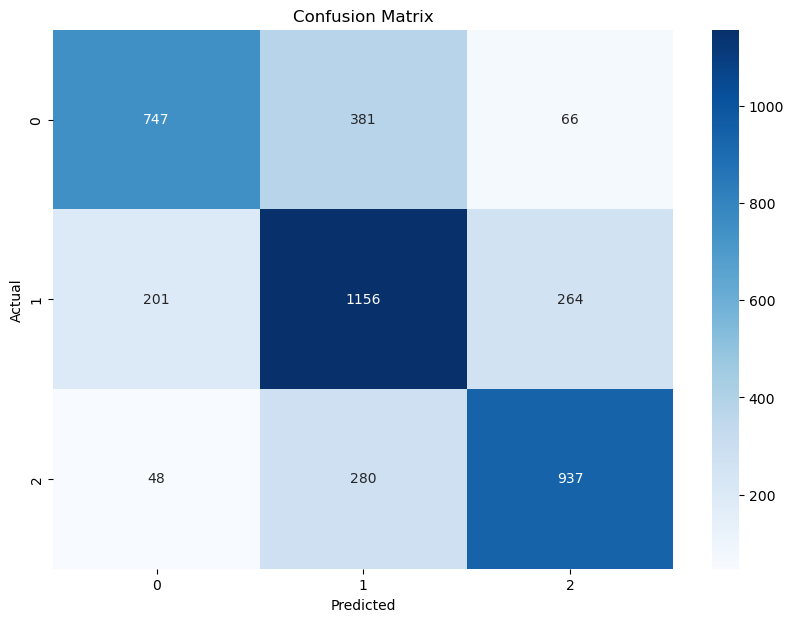

              precision    recall  f1-score   support

    Negative     0.7500    0.6256    0.6822      1194
     Neutral     0.6362    0.7131    0.6725      1621
    Positive     0.7395    0.7407    0.7401      1265

    accuracy                         0.6961      4080
   macro avg     0.7086    0.6932    0.6983      4080
weighted avg     0.7015    0.6961    0.6963      4080



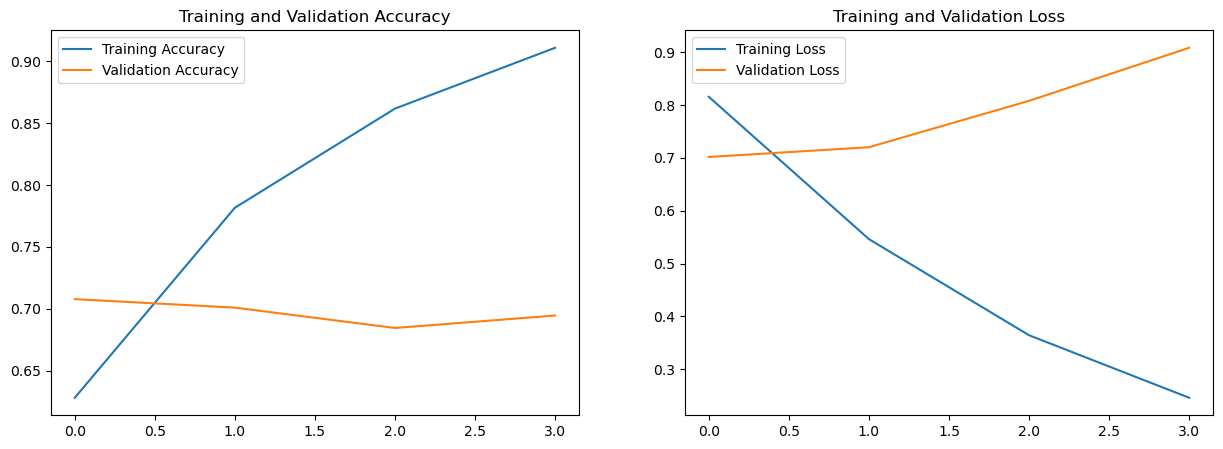

In [71]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 384, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.30000000000000004))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)
Y_test_argmax = np.argmax(Y_test, axis=-1)

plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

plot_training_history(history)

In [13]:
cm = np.array([[747, 381, 66], 
               [201, 1156, 264], 
               [48, 280, 937]])

compute_FPR_spec_metrics(cm)

Metrics for class negative (Class value: 0):
Specificity: 0.8937
FPR: 0.1063
Precision: 0.75

Metrics for class neutral (Class value: 1):
Specificity: 0.7181
FPR: 0.2819
Precision: 0.6362

Metrics for class positive (Class value: 2):
Specificity: 0.8522
FPR: 0.1478
Precision: 0.7395

Overall accuracy: 0.6961
Weighted average specificity: 0.8111
Weighted average FPR: 0.1889
Macro average specificity: 0.8213
Macro average FPR: 0.1787



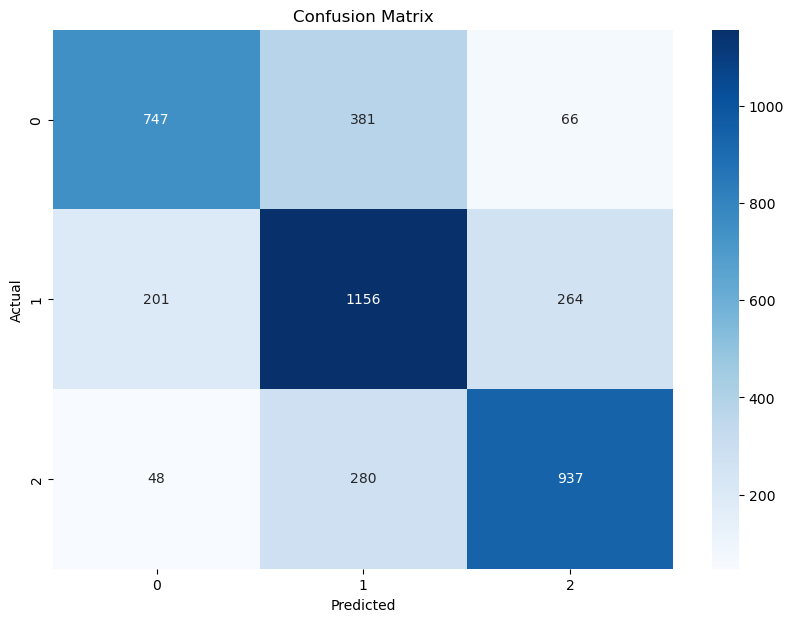

              precision    recall  f1-score   support

    Negative     0.7500    0.6256    0.6822      1194
     Neutral     0.6362    0.7131    0.6725      1621
    Positive     0.7395    0.7407    0.7401      1265

    accuracy                         0.6961      4080
   macro avg     0.7086    0.6932    0.6983      4080
weighted avg     0.7015    0.6961    0.6963      4080



In [72]:
plot_confusion_matrix(Y_test_argmax, test_pred)
print(classification_report(Y_test_argmax, test_pred, target_names=['Negative', 'Neutral', 'Positive'],digits=4))

In [73]:
misclassification_report(model, X_test, Y_test, tokenizer, n_samples=10)

128/128 [==============================] - 15s 117ms/step
1. how i wish the result is true
   True Sentiment: Neutral
   Misclassified as: Positive

2. making egg tart chinese egg pudding yum
   True Sentiment: Positive
   Misclassified as: Neutral

3. haaa awesome i remember my brother got given woody and i got upset cause i got buzz but then i got both of them lmfao
   True Sentiment: Positive
   Misclassified as: Neutral

4. on my way to school of my last friday of high school ever and i do not even get to see holly gabbie and hannah
   True Sentiment: Negative
   Misclassified as: Neutral

5. juz donated booksmags charity not only do i feel good but it gave me a good workout from all that heavy lifting
   True Sentiment: Positive
   Misclassified as: Neutral

6. oh and i am obviously back on my stupid sleep schedule luckily church is not until tomorrow
   True Sentiment: Neutral
   Misclassified as: Negative

7. umhow long has it been since you slept startin to worry over here well

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 384)          19200000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 384)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               525312    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 19726083 (75.25 MB)
Trainable params: 19726083 (75.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0
